# ⚙️ Import Libraries  

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns


# # 📂 Load Data 

## 🔗 Sumber Data  
Dataset yang digunakan berasal dari **Kaggle**:  
👉 [Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/code)  

Dataset ini berisi gambar biji padi dari berbagai varietas yang sering digunakan dalam penelitian pengolahan citra.  

In [2]:
image = os.listdir("Rice_Image_Dataset")
print('File Image : ', image)


File Image :  ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Rice_Citation_Request.txt']


In [3]:
dataset_dir = r"Rice_Image_Dataset"

Arborio_dir = os.path.join(dataset_dir, "Arborio")
Basmati_dir = os.path.join(dataset_dir, "Basmati")
Ipsala_dir = os.path.join(dataset_dir, "Ipsala")
Jasmine_dir = os.path.join(dataset_dir, "Jasmine")
Karacadag_dir = os.path.join(dataset_dir, "Karacadag")


Arborio_images = [os.path.join(Arborio_dir, f"Arborio ({i}).jpg") for i in range(1, 15001)]
Basmati_images = [os.path.join(Basmati_dir, f"Basmati ({i}).jpg") for i in range(1, 15001)]
Ipsala_images = [os.path.join(Ipsala_dir, f"Ipsala ({i}).jpg") for i in range(1, 15001)]
Jasmine_images = [os.path.join(Jasmine_dir, f"Jasmine ({i}).jpg") for i in range(1, 15001)]
Karacadag_images = [os.path.join(Karacadag_dir, f"Karacadag ({i}).jpg") for i in range(1, 15001)]


all_image_paths = Arborio_images + Basmati_images


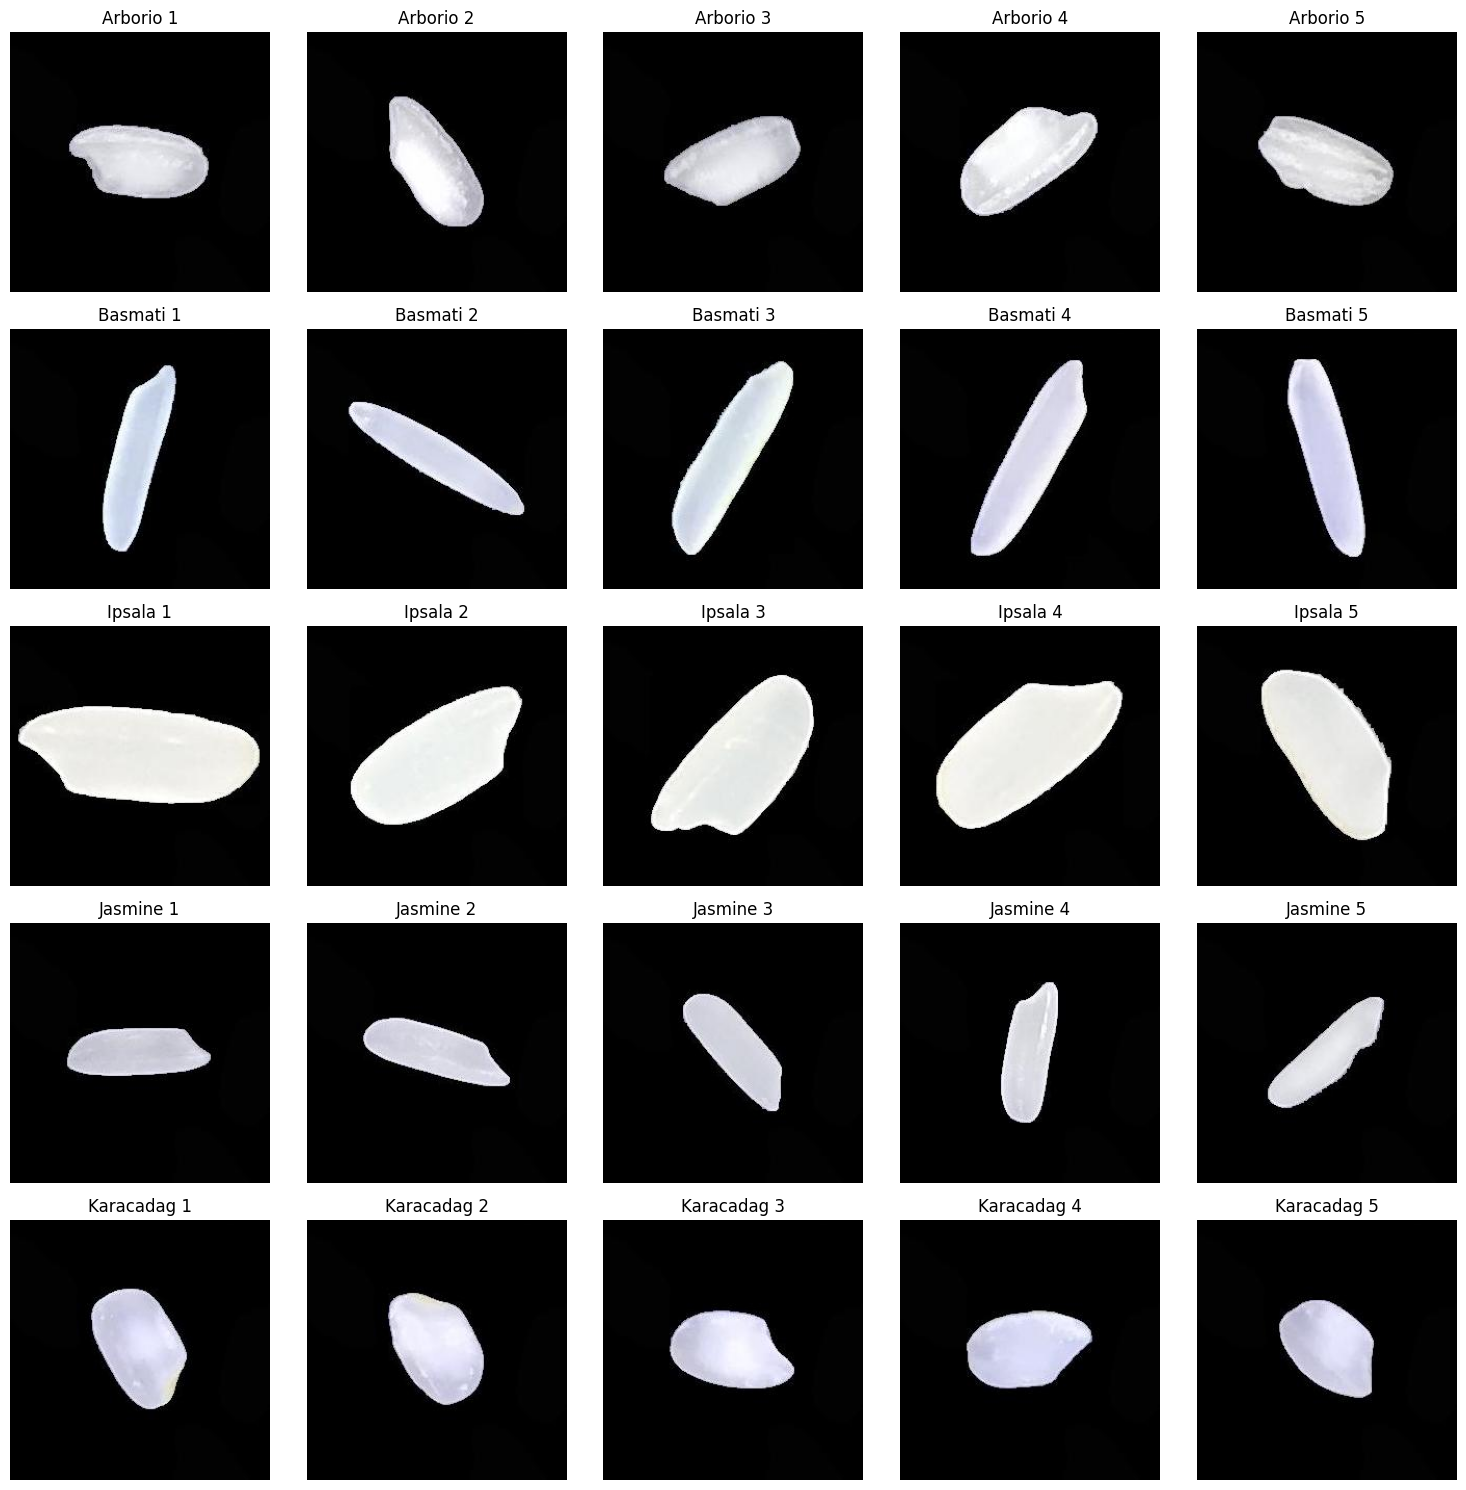

In [4]:
rice_dirs = {
    "Arborio": Arborio_dir,
    "Basmati": Basmati_dir,
    "Ipsala": Ipsala_dir,
    "Jasmine": Jasmine_dir,
    "Karacadag": Karacadag_dir
}

plt.figure(figsize=(15, 15))

for row_idx, (rice_name, rice_dir) in enumerate(rice_dirs.items()):
    files = os.listdir(rice_dir)
    for col_idx, file in enumerate(files[:5]):
        img = cv2.imread(os.path.join(rice_dir, file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        subplot_index = row_idx * 5 + col_idx + 1
        plt.subplot(len(rice_dirs), 5, subplot_index)
        plt.imshow(img_rgb)
        plt.title(f"{rice_name} {col_idx+1}")
        plt.axis("off")

plt.tight_layout()
plt.show()


## 📊 Keterangan Data  

| 🌾 Jenis Beras | 📸 Jumlah Gambar |
|----------------|------------------|
| Arborio       | 15.000 |
| Basmati       | 15.000 |
| Ipsala        | 15.000 |
| Jasmine       | 15.000 |
| Karacadag     | 15.000 |

✨ Total keseluruhan: **75.000 gambar**  

# 🧹 Data Preprocessing  

Pada tahap ini dilakukan pembersihan dan persiapan data citra agar siap digunakan oleh model CNN dan GAN.  


## 🔄 Tahapan Preprocessing  

- Menentukan direktori dataset, daftar kelas beras, ukuran gambar standar, dan jumlah maksimum gambar per kelas  
- Membuat fungsi preprocessing untuk:  
  - Membaca gambar dalam mode grayscale ⚫  
  - Mengubah ukuran menjadi seragam 📏  
  - Mengurangi noise dengan Gaussian Blur ✨  
  - Menyeimbangkan kontras dengan Histogram Equalization 🎛️  
- Melakukan iterasi untuk setiap kelas beras:  
  - Membaca sejumlah gambar sesuai batas maksimum  
  - Memproses setiap gambar dengan fungsi preprocessing  
  - Menyimpan citra hasil preprocessing beserta label kelasnya  
- Mengubah data menjadi format array siap pakai:  
  - Citra dinormalisasi ke rentang 0–1  
  - Label diubah ke bentuk One-Hot Encoding  
- Membagi dataset menjadi data latih (80%) dan data uji (20%) dengan distribusi kelas seimbang 

In [5]:
DATA_DIR = "Rice_Image_Dataset"
CLASSES = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
IMG_SIZE = 100
MAX_PER_CLASS = 1500 

def preprocess_image(img_path, img_size=100):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.resize(img, (img_size, img_size))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)

    return img

X, y = [], []

for label, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATA_DIR, class_name)
    img_names = os.listdir(class_path)[:MAX_PER_CLASS]

    for img_name in img_names:
        img_path = os.path.join(class_path, img_name)
        img = preprocess_image(img_path, IMG_SIZE)
        if img is not None:
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = to_categorical(y, num_classes=len(CLASSES))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Total data   : {X.shape[0]}")
print(f"X shape      : {X.shape}")
print(f"y shape      : {y.shape}")


Total data   : 7500
X shape      : (7500, 100, 100, 1)
y shape      : (7500, 5)


# 🧬 Generator GAN  

Generative Adversarial Network (GAN) digunakan untuk menghasilkan data sintetis yang menyerupai data asli.  
Pada tahap ini, GAN terdiri dari dua komponen utama:  
- **Generator** yang bertugas membuat gambar baru mirip dengan data asli.  
- **Discriminator** yang berfungsi membedakan antara gambar asli dan gambar hasil generator.  

Kedua model ini dilatih secara bersamaan sehingga generator semakin mahir menciptakan data tiruan yang sulit dibedakan dari data asli.  
Dalam penelitian ini, GAN dilatih untuk setiap kelas beras secara terpisah sehingga dapat memperkaya variasi data pada masing-masing kategori.  


In [6]:
img_shape = (100, 100, 1)
latent_dim = 100


def build_generator():
    return Sequential([
        Dense(25*25*128, input_dim=latent_dim),
        LeakyReLU(0.2),
        Reshape((25, 25, 128)),

        Conv2DTranspose(128, 4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2DTranspose(64, 4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2D(1, 7, activation="tanh", padding="same")
    ])


def build_discriminator():
    return Sequential([
        Conv2D(64, 4, strides=2, padding="same", input_shape=img_shape),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(128, 4, strides=2, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation="sigmoid")
    ])


In [7]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy",
                optimizer=Adam(0.01, 0.5))
    return gan


def train_gan(X_train_class, epochs=200, batch_size=32):
    X_train_class = X_train_class * 2 - 1
    half_batch = batch_size // 2

    generator = build_generator()
    discriminator = build_discriminator()
    discriminator.compile(
        loss="binary_crossentropy",
        optimizer=Adam(0.001, 0.5),
        metrics=["accuracy"]
    )
    gan = build_gan(generator, discriminator)

    d_losses, g_losses = [], []

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train_class.shape[0], half_batch)
        real_imgs = X_train_class[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(
            real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(
            fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}/{epochs} | D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}% | G loss: {g_loss:.4f}"
            )

    return generator, {"d_loss": d_losses, "g_loss": g_losses}


## 🌾 Generator GAN Arborio  

In [8]:
arborio_idx = CLASSES.index("Arborio")

arborio_samples = X_train[(y_train[:, arborio_idx] == 1)]

gan_arborio, history_arborio = train_gan(
    arborio_samples, epochs=100, batch_size=32)


Epoch 0/100 | D loss: 1.3678, acc: 18.75% | G loss: 1.1115
Epoch 20/100 | D loss: 0.0001, acc: 100.00% | G loss: 1.3242
Epoch 40/100 | D loss: 0.0000, acc: 100.00% | G loss: 1.4723
Epoch 60/100 | D loss: 0.0001, acc: 100.00% | G loss: 1.6114
Epoch 80/100 | D loss: 0.0000, acc: 100.00% | G loss: 1.8135


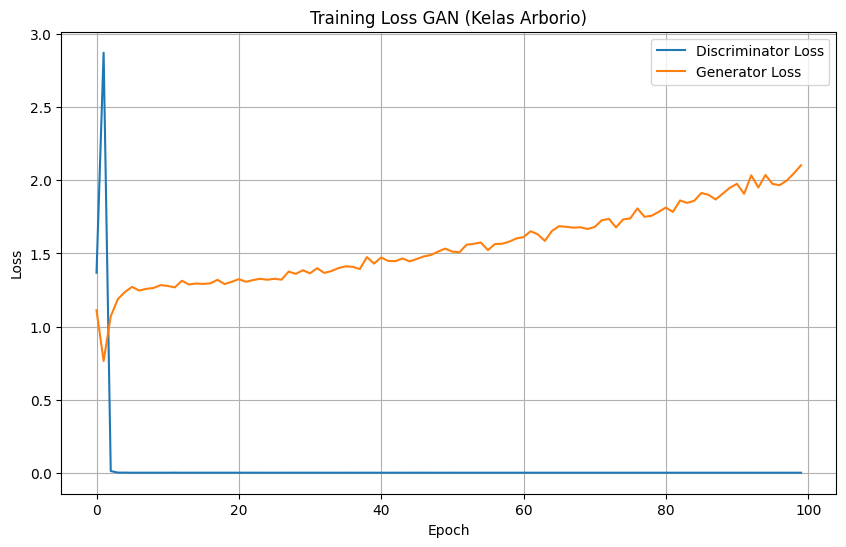

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history_arborio["d_loss"], label="Discriminator Loss")
plt.plot(history_arborio["g_loss"], label="Generator Loss")
plt.title("Training Loss GAN (Kelas Arborio)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🌾 Generator GAN Basmati  

In [10]:
basmati_idx = CLASSES.index("Basmati")
basmati_samples = X_train[(y_train[:, basmati_idx] == 1)]

gan_basmati, history_basmati = train_gan(
    basmati_samples, epochs=100, batch_size=32
)

Epoch 0/100 | D loss: 0.8622, acc: 15.62% | G loss: 0.6392
Epoch 20/100 | D loss: 0.0001, acc: 100.00% | G loss: 1.3975
Epoch 40/100 | D loss: 0.0000, acc: 100.00% | G loss: 1.5533
Epoch 60/100 | D loss: 0.0000, acc: 100.00% | G loss: 1.7120
Epoch 80/100 | D loss: 0.0000, acc: 100.00% | G loss: 2.0413


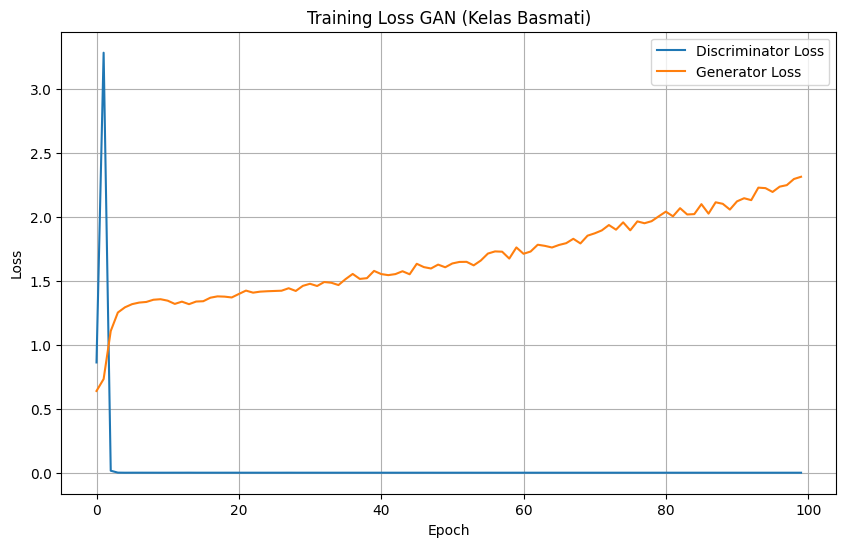

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history_basmati["d_loss"], label="Discriminator Loss")
plt.plot(history_basmati["g_loss"], label="Generator Loss")
plt.title("Training Loss GAN (Kelas Basmati)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🌾 Generator GAN Ipsala  

In [12]:
ipsala_idx = CLASSES.index("Ipsala")
ipsala_samples = X_train[(y_train[:, ipsala_idx] == 1)]

gan_ipsala, history_ipsala = train_gan(
    ipsala_samples, epochs=100, batch_size=32
)


Epoch 0/100 | D loss: 0.9331, acc: 21.88% | G loss: 0.8067
Epoch 20/100 | D loss: 0.0000, acc: 100.00% | G loss: 2.5263
Epoch 40/100 | D loss: 0.0000, acc: 100.00% | G loss: 2.5547
Epoch 60/100 | D loss: 0.0000, acc: 100.00% | G loss: 2.7307
Epoch 80/100 | D loss: 0.0000, acc: 100.00% | G loss: 3.0866


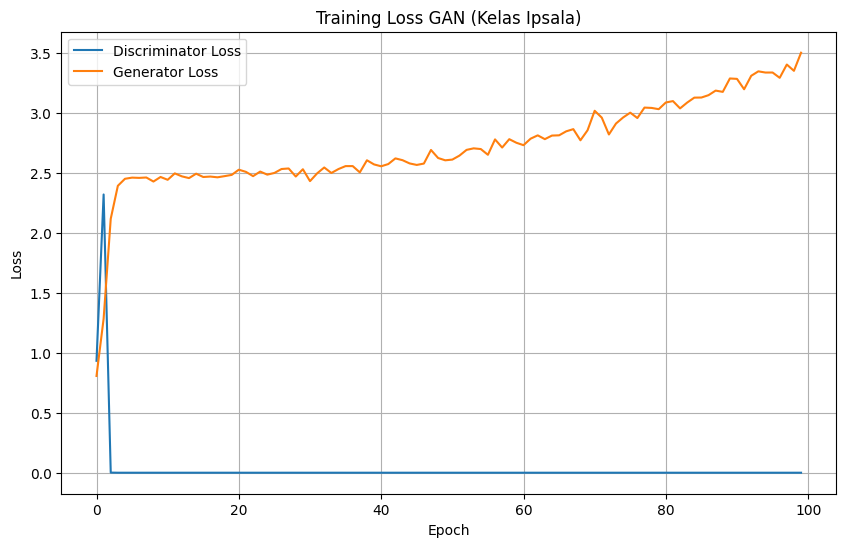

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history_ipsala["d_loss"], label="Discriminator Loss")
plt.plot(history_ipsala["g_loss"], label="Generator Loss")
plt.title("Training Loss GAN (Kelas Ipsala)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🌾 Generator GAN Jasmine 

In [14]:
jasmine_idx = CLASSES.index("Jasmine")
jasmine_samples = X_train[(y_train[:, jasmine_idx] == 1)]

gan_jasmine, history_jasmine = train_gan(
    jasmine_samples, epochs=100, batch_size=32
)


Epoch 0/100 | D loss: 1.4460, acc: 9.38% | G loss: 1.0246
Epoch 20/100 | D loss: 0.0002, acc: 100.00% | G loss: 1.5740
Epoch 40/100 | D loss: 0.0000, acc: 100.00% | G loss: 1.7633
Epoch 60/100 | D loss: 0.0001, acc: 100.00% | G loss: 1.9862
Epoch 80/100 | D loss: 0.0000, acc: 100.00% | G loss: 2.2857


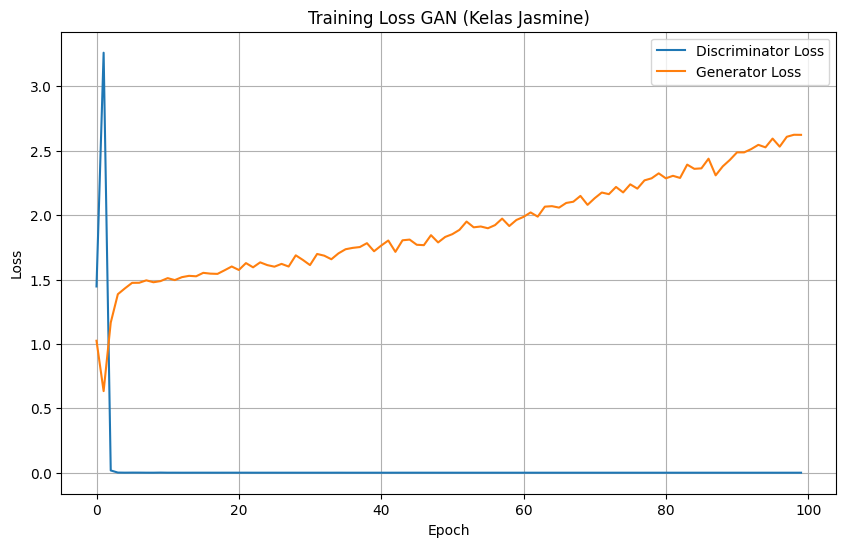

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history_jasmine["d_loss"], label="Discriminator Loss")
plt.plot(history_jasmine["g_loss"], label="Generator Loss")
plt.title("Training Loss GAN (Kelas Jasmine)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🌾 Generator GAN Karacadag 

In [16]:
karacadag_idx = CLASSES.index("Karacadag")
karacadag_samples = X_train[(y_train[:, karacadag_idx] == 1)]

gan_karacadag, history_karacadag = train_gan(
    karacadag_samples, epochs=100, batch_size=32
)


Epoch 0/100 | D loss: 1.1295, acc: 9.38% | G loss: 0.8294
Epoch 20/100 | D loss: 0.0002, acc: 100.00% | G loss: 1.3695
Epoch 40/100 | D loss: 0.0001, acc: 100.00% | G loss: 1.5301
Epoch 60/100 | D loss: 0.0001, acc: 100.00% | G loss: 1.6840
Epoch 80/100 | D loss: 0.0000, acc: 100.00% | G loss: 1.9251


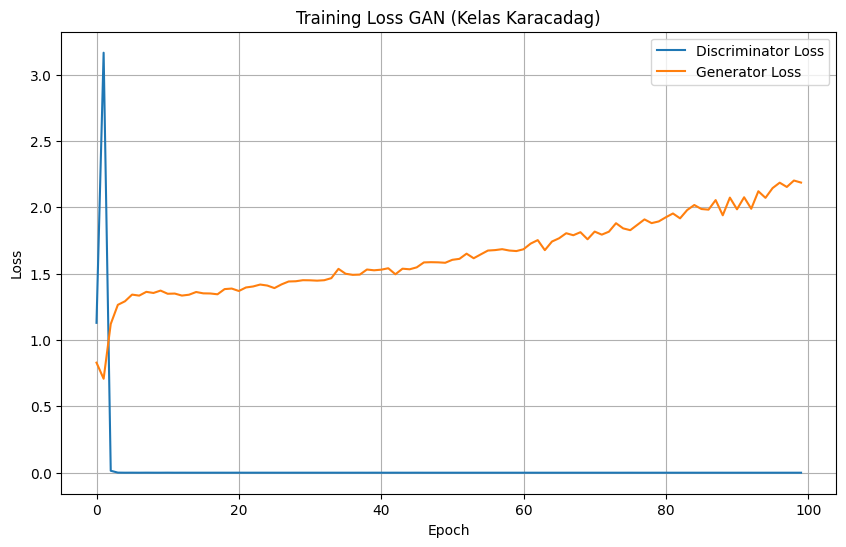

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history_karacadag["d_loss"], label="Discriminator Loss")
plt.plot(history_karacadag["g_loss"], label="Generator Loss")
plt.title("Training Loss GAN (Kelas Karacadag)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# 🧪 Augmentasi Data dengan Synthetic Images (GAN)  

Pada tahap ini dilakukan augmentasi data dengan menambahkan citra sintetis yang dihasilkan oleh model GAN.  
Setiap model GAN per kelas (*Arborio, Basmati, Ipsala, Jasmine, Karacadag*) digunakan untuk menghasilkan sejumlah gambar baru dari noise acak.  
Citra hasil sintesis kemudian digabungkan dengan data latih asli untuk membentuk dataset pelatihan yang lebih besar dan lebih bervariasi.  

Tujuan dari proses ini adalah:  
- ✨ Memperkaya variasi data sehingga model CNN tidak mudah overfitting.  
- 📈 Meningkatkan performa model pada data uji dengan generalisasi yang lebih baik.  
- 🔄 Menyeimbangkan distribusi data antar kelas dengan tambahan citra sintetis.  

Hasil akhirnya adalah dataset pelatihan gabungan (**real + synthetic**) yang jumlahnya lebih besar dibandingkan hanya menggunakan data asli.  

In [18]:
num_synth = 500 
latent_dim = 100

synth_images = []
synth_labels = []

for label, gen in enumerate([gan_arborio, gan_basmati,
                             gan_ipsala, gan_jasmine,
                             gan_karacadag]):
    noise = np.random.normal(0, 1, (num_synth, latent_dim))
    imgs = gen.predict(noise)
    imgs = 0.5 * imgs + 0.5
    synth_images.append(imgs)
    synth_labels.append(np.full((num_synth,), label))

X_synth = np.concatenate(synth_images, axis=0)
y_synth_indices = np.concatenate(synth_labels, axis=0)
y_synth = to_categorical(y_synth_indices, num_classes=len(CLASSES))


16/16 [==============================] - 4s 279ms/step


In [19]:
X_train_aug = np.concatenate([X_train, X_synth], axis=0)
y_train_aug = np.concatenate([y_train, y_synth], axis=0)

print("Total data train asli:", X_train.shape[0])
print("Total data train + sintetis:", X_train_aug.shape[0])
print("Total data test (real):", X_test.shape[0])


Total data train asli: 6000
Total data train + sintetis: 8500
Total data test (real): 1500


# 🏗️ Arsitektur CNN  

Convolutional Neural Network (CNN) digunakan sebagai model utama untuk melakukan klasifikasi citra beras.  
Model ini dirancang dengan beberapa lapisan konvolusi, pooling, dropout, dan fully connected layer untuk menangkap pola visual dari citra grayscale berukuran `100x100`.

In [20]:
num_classes = 5

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3), 

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## 🔨 Struktur Model  

- **Input Layer**: citra grayscale berukuran 100x100 piksel dengan 1 channel  
- **Conv2D (32 filter, kernel 3x3, ReLU)** → mengekstraksi fitur dasar dari citra  
- **MaxPooling2D (2x2)** → mereduksi dimensi fitur  
- **Dropout (0.3)** → mencegah overfitting  
- **Conv2D (64 filter, kernel 3x3, ReLU)** → mengekstraksi fitur lebih kompleks  
- **MaxPooling2D (2x2)** → mereduksi dimensi lebih lanjut  
- **Dropout (0.3)** → regularisasi tambahan  
- **Flatten** → mengubah hasil ekstraksi fitur menjadi vektor 1 dimensi  
- **Dense (128 neuron, ReLU, L2 regularizer)** → fully connected layer dengan regularisasi L2  
- **Dropout (0.5)** → mengurangi risiko overfitting  
- **Dense (5 neuron, Softmax)** → output layer untuk 5 kelas beras  

# 🚀 Training Model  

Proses pelatihan dilakukan dengan menggunakan dataset gabungan antara data asli dan data sintetis yang dihasilkan oleh GAN. Model CNN dijalankan dalam beberapa epoch sehingga bobot jaringan dapat menyesuaikan pola yang terdapat pada citra beras. Selama pelatihan, performa model dipantau melalui nilai akurasi dan loss baik pada data latih maupun validasi. Riwayat pelatihan kemudian digunakan untuk membuat grafik yang menunjukkan perkembangan kinerja model dari epoch ke epoch. Dengan cara ini, dapat dilihat apakah model mengalami peningkatan performa secara konsisten atau justru terjadi overfitting.  


In [21]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_aug, y_train_aug, test_size=0.2, random_state=42, stratify=y_train_aug
)

history = model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
)


Epoch 1/20
213/213 [==============================] - 52s 241ms/step - loss: 1.0301 - accuracy: 0.6074 - val_loss: 0.7448 - val_accuracy: 0.7212
Epoch 2/20
213/213 [==============================] - 51s 238ms/step - loss: 0.7412 - accuracy: 0.7131 - val_loss: 0.6873 - val_accuracy: 0.7212
Epoch 3/20
213/213 [==============================] - 51s 241ms/step - loss: 0.7178 - accuracy: 0.7463 - val_loss: 0.6749 - val_accuracy: 0.7694
Epoch 4/20
213/213 [==============================] - 51s 238ms/step - loss: 0.6841 - accuracy: 0.7631 - val_loss: 0.6431 - val_accuracy: 0.7894
Epoch 5/20
213/213 [==============================] - 58s 272ms/step - loss: 0.6473 - accuracy: 0.7751 - val_loss: 0.5747 - val_accuracy: 0.7976
Epoch 6/20
213/213 [==============================] - 60s 281ms/step - loss: 0.6177 - accuracy: 0.7796 - val_loss: 0.5786 - val_accuracy: 0.7882
Epoch 7/20
213/213 [==============================] - 60s 280ms/step - loss: 0.5874 - accuracy: 0.7843 - val_loss: 0.5602 - val_ac

# 📌 Evaluasi Model  

Setelah proses pelatihan selesai, model diuji menggunakan data uji yang benar-benar baru dan tidak pernah dilihat sebelumnya. Evaluasi ini bertujuan untuk mengukur kemampuan generalisasi model dalam mengenali jenis beras. Hasil evaluasi meliputi perhitungan akurasi keseluruhan, analisis confusion matrix untuk melihat distribusi prediksi antar kelas, serta laporan klasifikasi yang menampilkan nilai precision, recall, dan F1-score. Visualisasi evaluasi juga digunakan untuk mempermudah pemahaman performa model pada masing-masing kategori beras. Dari tahap ini dapat diketahui apakah model sudah cukup andal atau masih perlu dilakukan perbaikan.  


In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=2)


print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


47/47 - 2s - loss: 0.1944 - accuracy: 0.9733 - 2s/epoch - 35ms/step
Test Loss: 0.1944
Test Accuracy: 0.9733


In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) 


accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')


print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


47/47 [==============================] - 2s 34ms/step
Akurasi: 0.9733
Presisi: 0.9739
Recall: 0.9733
F1-Score: 0.9734


## 📃 Classification Report  

In [27]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))



Classification Report:
              precision    recall  f1-score   support

     Arborio       0.97      0.93      0.95       300
     Basmati       1.00      0.97      0.99       300
      Ipsala       1.00      0.99      0.99       300
     Jasmine       0.98      1.00      0.99       300
   Karacadag       0.93      0.98      0.95       300

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



## 🧩 Confusion Matrix  

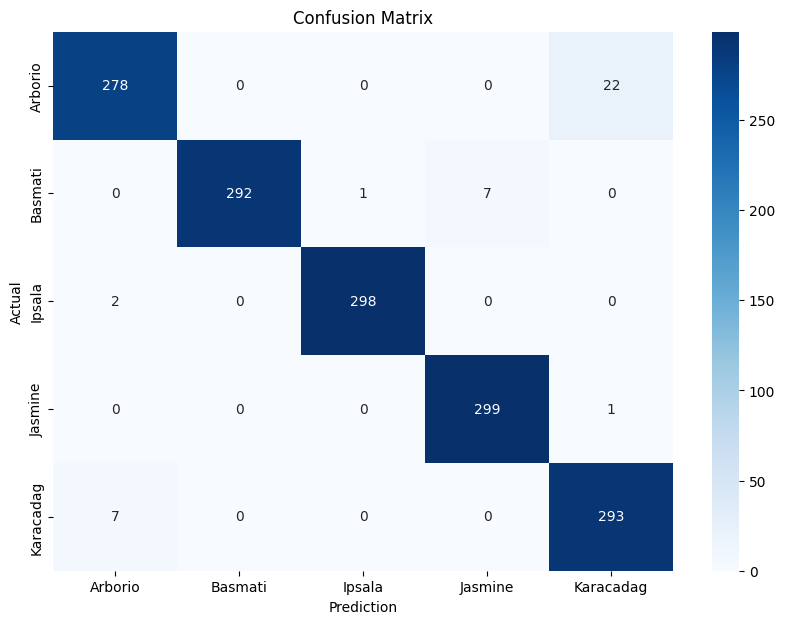

In [26]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()


# ✅ Conclusion  

Berdasarkan hasil evaluasi menggunakan data uji sebanyak **1.500 citra**, model CNN yang dikombinasikan dengan augmentasi data melalui GAN menunjukkan performa yang sangat baik.  

- 📌 **Akurasi keseluruhan** mencapai **97%**  
- 🌾 Hampir semua kelas beras memiliki nilai **precision, recall, dan f1-score di atas 0.95**  
- 🟢 **Basmati, Ipsala, dan Jasmine** mendapatkan skor hampir sempurna dengan nilai f1-score **0.99**  
- 🟡 **Arborio** dan **Karacadag** juga memiliki performa tinggi dengan f1-score **0.95**  

Secara umum, model mampu melakukan klasifikasi dengan tingkat keandalan yang tinggi pada seluruh kelas beras. Hal ini menunjukkan bahwa kombinasi **preprocessing citra, augmentasi data sintetis menggunakan GAN, dan arsitektur CNN** dapat bekerja secara efektif dalam mengenali berbagai varietas beras.  

✨ Dengan capaian ini, model memiliki potensi besar untuk digunakan pada sistem klasifikasi beras berbasis citra di dunia nyata.  
